# Reinforcement learning

Reinforcement learning komt uit de studie van Markov Chains of Processen voor.
Dit is een random opeenvolging van states waarbij elke transisitie een mogelijke kans heeft.
Door een reward te koppelen aan elke state waarin je komt kan je een functie opstellen die de de totale reward maximaliseert.
Dit is het basisidee achter reinforcement learning.

Een aantal belangrijke termen/concepten hierbij zijn:
* De agent
* Het environment
* De state space
* De action space
* De reward en return
* Exploration vs exploitation

## Q-learning

Een eerste algoritme dat we bekijken voor reinforcement learning uit te voeren is Q-learning.
Dit algoritme maakt gebruik van de Q-functie of action-value function.
Hiervoor houdt het Q-learning algoritme een matrix bij dat de reward van actie in een state bepaald.
In een verkenningsfase laten we toe dat er sub-optimale keuzes genomen worden.
Nadat dit lang genoeg gerund heeft, gaan we over naar een exploitation fase waarbij enkel de beste keuzes genomen worden.

Om te tonen hoe je het Q-learning algoritme kan implementeren, kan je gebruik maken van het gymnasium package.
Dit bevat heel wat eenvoudige environments van spelletjes in python die hiervoor gebruikt kunnen worden.
De bron voor onderstaande code komt van een [tutorial van de library](https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/)
In deze code gaan we experimenteren met het blackjack environment.

In [ ]:
import gymnasium as gym

# Create the Blackjack environment
env = gym.make('Blackjack-v1')

# Start a new Blackjack game (reset environment)
state = env.reset()

# Define actions (0 = Stick, 1 = Hit)
actions = {0: 'Stick', 1: 'Hit'}

# Function to display the state
def display_state(state):
    player_hand, dealer_hand, usable_ace = state
    print(f"Player's hand: {player_hand}, Dealer's showing: {dealer_hand}, Usable ace: {usable_ace}")

# Display initial state
display_state(state[0])

# Interactive function to play Blackjack manually
def play_blackjack(env):
    done = False
    while not done:
        action = int(input("Choose action - 0 (Stick) or 1 (Hit): "))
        
        # Take the action
        state, reward, terminated, trunctated, _ = env.step(action)
        done = terminated or truncated
        
        # Display the state after the action
        display_state(state)
        
        # Check if the game is finished
        if done:
            if reward > 0:
                print(f"You won! Reward: {reward}")
            elif reward < 0:
                print(f"You lost! Reward: {reward}")
            else:
                print(f"Game ended in a draw. Reward: {reward}")

# Start the game
play_blackjack(env)


Merk op dat er twee mogelijke acties zijn: 0 en 1 om een extra kaart te nemen of niet.

De state bestaat uit drie waarden:
* Je eigen hand
* De hand van de dealer
* Het aantal bruikbare aces

In de code hieronder gaan we een agent schrijven die het Q-Learning algoritme implementeert voor het blackjack environment.

In [ ]:
import numpy as np

class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = {}   # Gaan we de Q-values in opslaan (1 per observatie)

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        if obs not in self.q_values:
            self.q_values[obs] = np.zeros(env.action_space.n)
            
        if np.random.random() < self.epsilon:
            # exploration (random)
            return env.action_space.sample()
        else:
            # exploitation (greedy)
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        if obs not in self.q_values:
            self.q_values[obs] = np.zeros(env.action_space.n)

        if next_obs not in self.q_values:
            self.q_values[next_obs] = np.zeros(env.action_space.n)

        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        # Update the Q-value
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):            # in het begin grote epsilon -> neem veel random zetten, later kleinere epsilon zodat er vooral de beste zet genomen wordt
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

Op dit moment kunnen we deze agent een aantal keer blackjack laten spelen om te leren welke acties tot positieve rewards en welke tot negatieve rewards leiden.
Dit gebeurd in de code hieronder waar we ook gebruik maken van de tqdm package om een progress-bar te tonen tijdens het uitvoeren.

In [ ]:
from tqdm import tqdm
import gymnasium as gym

# Create the Blackjack environment
env = gym.make('Blackjack-v1')

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

Bovenstaande leerproces is echter nog niet geevalueerd. We hebben dus nog geen idee of de geleerde agent een gewenst gedrag geleerd heeft.
Om deze reden is er hierboven gebruik gemaakt van de RecordEpisodeStatistics wrapper die informatie bijhoudt over het leerproces.
Hieronder maken we enkele grafieken om de prestatie van de agent te analyseren.

In [ ]:
import matplotlib.pyplot as plt

rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict
import seaborn as sns
from matplotlib.patches import Patch

def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

In [ ]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

## Hoe goed presteert de agent?

In onderstaande code gaan we de agent een 10-tal keer laten blackjack spelen. 
Hierbij gaan we bijhouden hoe vaak de agent wint.

In [ ]:
# Create the Blackjack environment
env = gym.make('Blackjack-v1')

# Define actions (0 = Stick, 1 = Hit)
actions = {0: 'Stick', 1: 'Hit'}

# Function to display the state
def display_state(state):
    player_hand, dealer_hand, usable_ace = state
    print(f"Player's hand: {player_hand}, Dealer's showing: {dealer_hand}, Usable ace: {usable_ace}")

# Function to play one game of Blackjack
def play_blackjack(env, agent=None, random=False):
    state = env.reset()
    done = False
    while not done:
        if agent is None and random:
            action = random.randint(0, 1)
        elif agent is None:
            action = int(input("Choose action - 0 (Stick) or 1 (Hit): "))
        else:
            action = agent.get_action(obs)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Optionally, display the state after the action
        display_state(state)
        
    return reward

# Number of games to play
num_games = 10
wins = 0

# Play the game num_games times
for i in range(num_games):
    reward = play_blackjack(env, agent)
    if reward > 0:
        wins += 1
    elif reward < 0:
        print(f"Game {i+1}: You lost! Reward: {reward}")
    else:
        print(f"Game {i+1}: Game ended in a draw. Reward: {reward}")

print(f"Total games played: {num_games}")
print(f"Number of wins: {wins}")


## RL in neural networks

Het gebruik van Q-learning werkt goed als het aantal states en acties beperkt zijn.
Dit is echter zelden het geval, denk bijvoorbeeld aan een continue variabele zoals snelheid of locatie.

Een oplossing hiervoor is om de action-value functie die in Q-learning geoptimaliseerd wordt te benaderen ipv exact te berekenen.
Dit kan bijvoorbeeld door middel van een neuraal netwerk te gebruiken.
Er zijn verschillende model-structuren die hiervoor ontwikkeld zijn zoals:
- DQN (onderwerp van onderstaande demo)
- REINFORCE
- DDPG
- TD3
- PPO
- SAC

Voor we beginnen met het uitwerken van een model.
Bekijk [deze tutorial](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial) en beantwoord de volgende vragen:
- Wat is de state en wat zijn de mogelijke acties?
- Wat is de structuur van het gebruikte DQN?
- Zijn er nieuwe hyperparameters gebruikt?
- Welke metriek wordt er gebruikt en waar wordt deze berekend?
- Hoe worden de gewichten aangepast?
- Waarvoor wordt de ReplayBuffer gebruikt?

**Antwoord:**
- Vraag 1:
    - State: de positie en snelheid van het karretje en de hoek/hoeksnelheid van de staaf.
    - Acties: Beweeg naar links en beweeg naar rechts
- Vraag 2: Er zijn drie lagen met respectievelijk 100, 50 en 2 neuronen. Het is belangrijk dat het aantal neuronen in de laatste laag overeenkomt met het aantal acties.
- Vraag 3: De enige nieuwe hyperparameter bij het aanmaken van het neuraal netwerk is de initialiser. De hidden lagen gebruiken een VarianceScaler als kernel-initalisator wat inhoudt dat ze gesampled worden uit een Normaalverdeling. De outputlayer gebruikt een RandomUniform kernel-initializer (sample de gewichten uit een uniforme verdeling) en een constante waarde als bias-initializer
- Vraag 4: De average return wordt hiervoor gebruikt en deze wordt [hier](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial#metrics_and_evaluation) berekend. De return is de tijd dat de staaf omhoog blijft (1 voor elke tijdstap)
- Vraag 5 en 6: Je laadt het netwerk wat lopen, de uitgevoerde acties en bekomen rewards worden opgeslaan in de ReplayBuffer. Batches of data worden uit de replaybuffer gehaald om het netwerk te trainen op basis van de gemiddelde return

Schrijf nu zelf de nodige code om het DQN-model toe te passen op het "Pole-cart" environment van gymnasium.
Hieronder vind je de nodige code om een visualisatie te maken van het uitvoeren van het pole-cart environment.
Om ervoor te zorgen dat de simulatie niet te snel stopt worden er altijd 1000 stappen gesimuleerd en wordt het gereset bij falen.
In de realiteit stop je het environment na een kritisch falen echter.

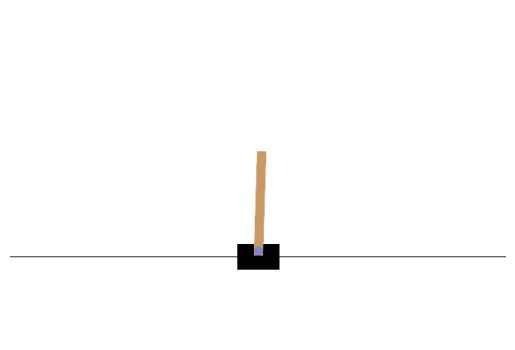

In [58]:
import gymnasium as gym
from IPython.display import display, clear_output

def display_env(env):
    """Function to display the environment inline in a Jupyter notebook."""
    img = env.render()
    plt.imshow(img)
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)

env = gym.make('CartPole-v1', render_mode="rgb_array")
observation, info = env.reset(seed=42)
for _ in range(100):

    display_env(env)
    
    action = env.action_space.sample()  # this is where you would insert your policy
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

Create a neural network to approximate the Q-value function (regression for each possible action).
De bron van deze code kan je hier vinden: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [210]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython.display import display, clear_output

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

Om een DQN-netwerk stabieler te trainen wordt een replay-buffer in het leven geroepen.
Deze houdt alle observaties bij die tegenkomen worden en maakt het mogelijk om hier samples uit te nemen.
Dit zorgt ervoor dat de tijds-correlatie verdwijnt wat het resultaat stabieler maakt.
Deze buffer schrijven we als volgt:

In [211]:
# welke data bijgehouden wordt in het geheugen
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Daarna kunnen we het neuraal netwerk opbouwen om de Q-value horende bij de acties te benaderen voor elke state.
Het aantal inputs is dus gelijk aan de observaties en de outputs aan het aantal mogelijke acties.
De opbouw van het netwerk ertussen kan je vrij kiezen

In [213]:
class DQN(nn.Module):

     def __init__(self, state_size, action_size, layer_sizes=(100, 50), learning_rate=0.0001):
        super(DQNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.layer_sizes = layer_sizes

        # Define the network architecture
        layers = []
        input_size = state_size

        for hidden_size in layer_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, action_size))  # Output layer with action_size units
        self.network = nn.Sequential(*layers)

        # Define the optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def forward(self, state):
        return self.network(state)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 25)

Op basis van dit netwerk kunnenn we dan een agent definieren die het mogelijk maakt om het netwerk te trainen en acties te voorspellen.
De basis-structuur van deze agent ziet eruit als volgt:

In [214]:
class DQNAgent:

    def __init__(self, env, buffer_size=int(1e5), batch_size=64, gamma=0.99, tau=1e-3, lr=5e-4, eps_start=0.9, eps_end=0.05, eps_decay=1000, layers=[20]):
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.steps = 0
        self.lr = lr
        
        self.Q_targets = 0.0
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n

        print("Initialising DDQN Agent with params : {}".format(self.__dict__))

        # Make local & target model
        print("Initialising Local DQNetwork")
        self.policy_network = DQNetwork(self.state_size, self.action_size,
                                       layer_sizes=layers,
                                       learning_rate=lr)

        print("Initialising Target DQNetwork")
        self.target_network = DQNetwork(self.state_size, self.action_size,
                                        layer_sizes=layers,
                                        learning_rate=lr)
        self.target_network.load_state_dict(self.policy_network.state_dict())

        self.memory = ReplayMemory(capacity=buffer_size)

    def reset(self):
        self.last_state = state
        self.steps = 0
        return state

    def act(self, state, eps=0.):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps / self.eps_decay)
        self.steps += 1
        
        if random.random() > eps_threshold:
            with torch.no_grad():
                return self.policy_network(state).max(1).indices.item()
        else:
            return np.random.randint(self.action_size)

    def step(self, state, action, next_state, reward, done):
        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        action = torch.tensor(action, dtype=torch.float32).unsqueeze(0)
        reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(0)
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            
        self.memory.push(state, action, next_state, reward)
        self.optimize_model()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))  
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action).to(torch.int64).unsqueeze(-1)
        reward_batch = torch.cat(batch.reward)   
        
        # Q(s_t, a)
        state_action_values = self.policy_network(state_batch).gather(1, action_batch) 
        
        next_state_values = torch.zeros(self.batch_size)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1).values
        
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # update weights
        loss = self.policy_network.criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        self.policy_network.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100) # In-place gradient clipping
        self.policy_network.optimizer.step()

    def update_target_model(self):
        target_net_state_dict = self.target_network.state_dict()
        policy_net_state_dict = self.policy_network.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
        self.target_network.load_state_dict(target_net_state_dict)


episode_durations = []
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display(plt.gcf())
            clear_output(wait=True)
        else:
            display(plt.gcf())

In [ ]:
#training the agent
from tqdm import tqdm
from itertools import count

env = gym.make('CartPole-v1', render_mode="rgb_array")
agent = DQNAgent(env, 
                 buffer_size=10000, 
                 batch_size=16, 
                 gamma=0.99, 
                 tau=1e-3, 
                 lr=5e-4, 
                 eps_start=0.9, eps_end=0.05, eps_decay=1000, 
                 layers=[20])
num_episodes = 500

for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    state, info = env.reset()
    agent.reset()
    
    done = False
    while not done:
        action = agent.act(state)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.step(state, action, next_state, reward, done)
        
    episode_durations.append(agent.steps + 1)
    plot_durations()

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

 61%|██████    | 304/500 [12:48<27:38,  8.46s/it]

In [207]:

from IPython.display import display, clear_output

# Function to play one game of Blackjack
def play(env, agent):
    state, info = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        display_env(env)
        
    return reward

In [208]:
play(env,agent)

1.0